### TP-2 : Implémentation de l'Autodifférentiation en Mode Forward

### Objectif

L'objectif de ce TP est d'implémenter l'autodifférentiation en mode forward en utilisant des nombres duals. Vous allez créer une classe Python qui représente un tenseur contenant une partie réelle et une partie duale, et implémenter les opérations arithmétiques de base (addition, soustraction, multiplication, division, puissance) ainsi que la différentiation automatique en mode forward.


### Principe de la méthode d'autodifférentiation en mode forward

L'autodifférentiation (ou différentiation automatique) est une technique utilisée pour calculer les dérivées de fonctions définies par des programmes informatiques. Contrairement aux méthodes de dérivation symbolique ou numérique, l'autodifférentiation est précise et efficace. Il existe deux modes principaux : le mode forward et le mode reverse.
En mode forward, l'idée est de propager des paires de valeurs (la valeur de la fonction et la valeur de sa dérivée) à travers chaque opération élémentaire de la fonction. Voici comment cela fonctionne :

1. **Initialisation** : On commence par associer à chaque variable d'entrée une paire de valeurs $(x_i, \dot{x}_i)$, où $x_i$ est la valeur de la variable et $\dot{x}_i$ est la dérivée de la variable par rapport à l'entrée d'intérêt (souvent initialisée à 1 pour la variable d'intérêt et à 0 pour les autres).

2. **Propagation** : À chaque étape de la fonction, pour chaque opération élémentaire (comme l'addition, la multiplication, etc.), on calcule à la fois la nouvelle valeur de la fonction et la nouvelle valeur de la dérivée. Par exemple, pour une opération élémentaire $z = x + y$, on aurait :
   - Valeur : $z = x + y$
   - Dérivée : $\dot{z} = \dot{x} + \dot{y}$
   
   Pour une multiplication $z = x \cdot y$, on aurait :
   - Valeur : $z = x \cdot y$
   - Dérivée : $\dot{z} = \dot{x} \cdot y + x \cdot \dot{y}$

3. **Résultat** : À la fin de la propagation, on obtient la valeur finale de la fonction ainsi que la valeur de sa dérivée par rapport à l'entrée d'intérêt.

### Exemple simple

Supposons que nous voulons dériver la fonction $f(x) = x^2 + 3x$ par rapport à $x$.

1. **Initialisation** :
   - $x = x$
   - $\dot{x} = 1$ (puisque nous dérivons par rapport à $x$)

2. **Propagation** :
   - Première opération : $u = x^2$
     - $u = x \cdot x$
     - $\dot{u} = \dot{x} \cdot x + x \cdot \dot{x} = 1 \cdot x + x \cdot 1 = 2x$
   - Deuxième opération : $v = 3x$
     - $v = 3 \cdot x$
     - $\dot{v} = 3 \cdot \dot{x} = 3 \cdot 1 = 3$
   - Troisième opération : $f = u + v$
     - $f = u + v$
     - $\dot{f} = \dot{u} + \dot{v} = 2x + 3$

3. **Résultat** :
   - La valeur de la fonction est $f(x) = x^2 + 3x$
   - La dérivée de la fonction est $\dot{f} = 2x + 3$

Bon travail et bonne programmation !

### Préliminaire, surcharge des opérateurs et plot du graphe de calcul

1. Observer et décrire la classe et le first_test
2. Remarquer comment la surcharge d'opérateur permet de propager le graphe de calcul
2. Adapter la classe pour rendre le second_test fonctionnel

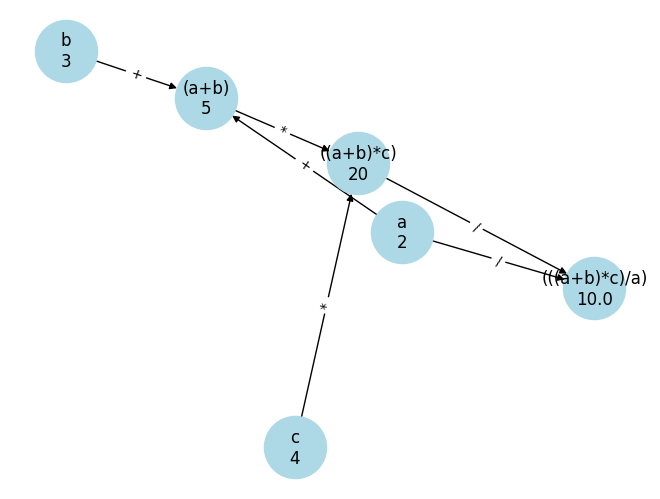

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

class TensorSimple:
    graph = nx.DiGraph()  # Create a directed graph

    def __init__(self, data, name=None):
        self.data = np.array(data)
        self.name = name
        TensorSimple.graph.add_node(self)  # Add the current tensor as a node in the graph
        self.operation = None
        self.result = None

    def __add__(self, other):
        result = TensorSimple(self.data + other.data, name=f"({self.name}+{other.name})")
        self._add_edge(other, result, '+')
        return result

    def __sub__(self, other):
        result = TensorSimple(self.data - other.data, name=f"({self.name}-{other.name})")
        self._add_edge(other, result, '-')
        return result

    def __mul__(self, other):
        result = TensorSimple(self.data * other.data, name=f"({self.name}*{other.name})")
        self._add_edge(other, result, '*')
        return result

    def __truediv__(self, other):
        result = TensorSimple(self.data / other.data, name=f"({self.name}/{other.name})")
        self._add_edge(other, result, '/')
        return result

    def __pow__(self, other):
        result = TensorSimple(self.data ** other.data, name=f"({self.name}^{other.name})")
        self._add_edge(other, result, '^')
        return result

    def _add_edge(self, other, result, operation):
        TensorSimple.graph.add_edge(self, result, operation=operation)
        TensorSimple.graph.add_edge(other, result, operation=operation)
        result.operation = operation
        result.result = result

    def __repr__(self):
        return str(self.data)


def plot_graph(graph):
    pos = nx.spring_layout(graph)
    labels = {node: f"{node.name}\n{node.data}" for node in graph.nodes}
    edge_labels = {(u, v): f"{d['operation']}" for u, v, d in graph.edges(data=True)}
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=2000, node_color='lightblue')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()


def first_test():

    TensorSimple.graph = nx.DiGraph()

    # Create some tensors
    a = TensorSimple(2, name='a')
    b = TensorSimple(3, name='b')
    c = TensorSimple(4, name='c')

    # Perform some operations
    d = a + b
    e = d * c
    f = e / a

    # Draw the computational graph
    plot_graph(TensorSimple.graph)

if __name__ == '__main__':
    first_test()

### Autodifférentiation en mode forward

Vous allez implémenter une classe `Tensor` qui représente un nombre dual. Chaque `Tensor` contient deux attributs :
- `real` : la partie réelle du nombre.
- `dual` : un dictionnaire représentant la partie duale, où les clés sont des indices nommés et les valeurs sont les valeurs duales correspondantes.

### Méthodes à Implémenter

1. **Constructeur (`__init__`)** :
    - Initialise un `Tensor` avec une partie réelle et une partie duale.

2. **Addition (`__add__` et `__radd__`)** :
    - Permet l'addition de deux tenseurs ou l'addition d'un scalaire à un tenseur.

3. **Soustraction (`__sub__` et `__rsub__`)** :
    - Permet la soustraction de deux tenseurs ou la soustraction d'un scalaire d'un tenseur.

4. **Multiplication (`__mul__` et `__rmul__`)** :
    - Permet la multiplication de deux tenseurs ou la multiplication d'un scalaire par un tenseur.

5. **Division (`__truediv__` et `__rtruediv__`)** :
    - Permet la division de deux tenseurs ou la division d'un scalaire par un tenseur.

6. **Puissance (`__pow__`)** :
    - Permet d'élever un tenseur à une puissance donnée.

7. **Négation (`__neg__`)** :
    - Permet de négativer un tenseur.

8. **Méthode auxiliaire `div_neg`** :
    - Permet de négativer la partie duale d'un tenseur.

9. **Représentation en chaîne (`__str__`)** :
    - Retourne une représentation en chaîne de caractères du tenseur.

### Instructions

1. Implémentez la classe `Tensor` avec les méthodes décrites ci-dessus.
2. Testez chaque méthode avec des exemples concrets pour vérifier leur bon fonctionnement.
3. Documentez votre code et commentez chaque méthode pour expliquer son fonctionnement.


In [10]:
import numpy as np

class Tensor:

    def __init__(self, real, dual):
        '''
        real: real number
        dual: dict (key=name_index and value=value)
        '''
        self.real = real  # The real part of the dual number
        self.dual = dual  # The dual part of the dual number

    def __add__(self, argument):


        if isinstance(argument, Tensor):
        
            real = self.real + argument.real

            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key]
            
            for key in argument.dual:
                if key in dual:
                    dual[key] += argument.dual[key]
                else:
                    dual[key] = argument.dual[key]

            return Tensor(real, dual)
        

        else:
            return Tensor(self.real + argument, self.dual)
        
    __radd__ = __add__
    
    def __mul__(self, argument):

        ## Tensor
        if isinstance(argument, Tensor):
            real = self.real * argument.real

            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] * argument.real

            for key in argument.dual:
                if key in dual:
                    dual[key] += argument.dual[key] * self.real
                else:
                    dual[key] = argument.dual[key] * self.real

            return Tensor(real, dual)
        
        else: ## Constante
            real = self.real * argument
            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] * argument
            return Tensor(real, dual)
        
    __rmul__ = __mul__
    
    def __sub__(self, argument):
        
        if (isinstance(argument, Tensor)):
            real = self.real - argument.real

            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] - argument.dual.get(key, 0)
            
            for key in argument.dual:
                if key not in dual:
                    dual[key] = -argument.dual[key]

            return Tensor(real, dual)
        else:
            return Tensor(self.real - argument, self.dual)    
        
    def __rsub__(self, argument):
        result = Tensor(argument, {}) - self
        return result
    
    def __truediv__(self, argument):
            ## Tensor
        if isinstance(argument, Tensor):
            # calcul de la partie réelle
            real = self.real / argument.real

            # calcul de la partie duale
            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] / argument.real

            for key in argument.dual:
                if key in dual:
                    dual[key] -= (self.real * argument.dual[key]) / (argument.real ** 2)
                else:
                    dual[key] = -(self.real * argument.dual[key]) / (argument.real ** 2)

            return Tensor(real, dual)
      
    def __rtruediv__(self,argument):
        result = Tensor(argument, {}) / self
        return result
        
  
    def __pow__(self, power):
        if isinstance(power, (int, float)):
            real = self.real ** power
            dual = {}
            for key in self.dual:
                dual[key] = self.dual[key] * power * (self.real ** (power - 1))

            return Tensor(real, dual)
        raise NotImplementedError()

    def __neg__(self):
        real = -self.real
        dual = {}
        for key in self.dual:
            dual[key] = -self.dual[key]
        return Tensor(real, dual)
    
    def __str__(self):
        s = 'f = ' + str(round(self.real,6)) + '\n'
        for key in self.dual:
            s += 'f' + key + ' = ' + str(round(self.dual[key],6)) + '\n'
        return s


In [11]:
### Test d'autodifférentiation pour l'addition
import torch

if __name__ == '__main__':


    ## Test the class
    # f(x) = aW + b
    # c(x,y) = f(x) - y    
    
    ## Parameters
    W = Tensor(3, {'W': 1})
    b = Tensor(2, {'b': 1})
    
    ## Constantes
    x = 2
    y = 4

    f = x*W + b
    cost = f - y
    print("--- Premier Test ---")
    print("Wolf Forward Mode:")
    print(cost)

    # PyTorch comparison
    W_torch = torch.tensor(3.0, requires_grad=True)
    b_torch = torch.tensor(2.0, requires_grad=True)
    x_torch = 2.0
    y_torch = 4.0

    f_torch = x_torch * W_torch + b_torch
    cost_torch = f_torch - y_torch
    cost_torch.backward()
    
    print("PyTorch:")
    print(f"cost: {cost_torch.item()}")
    print(f"grad W: {W_torch.grad.item()}")
    print(f"grad b: {b_torch.grad.item()}")
    print()

    ############################

    ## Constantes
    x_anchor = 2
    x_pos = 4
    x_neg = 1

    f_anchor = x_anchor*W + b
    f_pos = x_pos*W + b
    f_neg = x_neg*W + b

    cost =  (f_anchor * f_pos) - (f_anchor * f_neg)
    print("--- Second Test ---")
    print("Wolf Forward Mode:")
    print(cost)

    # PyTorch comparison
    W_torch.grad.zero_()
    b_torch.grad.zero_()

    f_anchor_torch = x_anchor * W_torch + b_torch
    f_pos_torch = x_pos * W_torch + b_torch
    f_neg_torch = x_neg * W_torch + b_torch

    cost_complex_torch = (f_anchor_torch * f_pos_torch) - (f_anchor_torch * f_neg_torch)
    cost_complex_torch.backward()

    print("PyTorch:")
    print(f"cost: {cost_complex_torch.item()}")
    print(f"grad W: {W_torch.grad.item()}")
    print(f"grad b: {b_torch.grad.item()}")

--- Premier Test ---
Wolf Forward Mode:
f = 4
fW = 2
fb = 1

PyTorch:
cost: 4.0
grad W: 2.0
grad b: 1.0

--- Second Test ---
Wolf Forward Mode:
f = 72
fW = 42
fb = 9

PyTorch:
cost: 72.0
grad W: 42.0
grad b: 9.0


### Fonctions Mathématiques avec des Nombres Duals pour l'Autodifférentiation

### Objectif

L'objectif de cette partie du TP est d'implémenter des fonctions mathématiques couramment utilisées dans le contexte de l'autodifférentiation en mode forward en utilisant des nombres duals. Vous allez créer des fonctions qui calculent à la fois la valeur d'une fonction mathématique et sa dérivée, représentée par la partie duale.
Vous allez implémenter plusieurs fonctions mathématiques en utilisant des nombres duals représentés par la classe `Tensor`. Chaque fonction doit calculer la valeur de la fonction et la dérivée, et renvoyer un objet `Tensor` contenant ces informations.

### Fonctions à Implémenter

1. **Logarithme naturel (`log_d`)** :
    - Calcule la valeur du logarithme naturel et sa dérivée.

2. **Exponentielle (`exp_d`)** :
    - Calcule la valeur de l'exponentielle et sa dérivée.

3. **Sinus (`sin_d`)** :
    - Calcule la valeur du sinus et sa dérivée.

4. **Cosinus (`cos_d`)** :
    - Calcule la valeur du cosinus et sa dérivée.

5. **Sigmoïde (`sigmoid_d`)** :
    - Calcule la valeur de la fonction sigmoïde et sa dérivée.

6. **Tangente hyperbolique (`tanh_d`)** :
    - Calcule la valeur de la tangente hyperbolique et sa dérivée.

7. **Tangente (`tan_d`)** :
    - Calcule la valeur de la tangente et sa dérivée.

8. **Racine carrée (`sqrt_d`)** :
    - Calcule la valeur de la racine carrée et sa dérivée.

9. **Puissance (`pow_d`)** :
    - Calcule la valeur de la fonction puissance et sa dérivée.


### Instructions

1. Implémentez les fonctions décrites ci-dessus.
2. Testez chaque fonction avec des exemples concrets pour vérifier leur bon fonctionnement.
3. Documentez votre code et commentez chaque fonction pour expliquer son fonctionnement.


In [12]:
def sin_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = np.sin(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * np.cos(a)
    return Tensor(sa, dual)

def cos_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = np.cos(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * (-np.sin(a))
    return Tensor(sa, dual)

def log_d(dual_number):    
    dual = {}
    a = dual_number.real
    sa = np.log(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] / a
    return Tensor(sa, dual)

def exp_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = np.exp(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * np.exp(a)
    return Tensor(sa, dual)

def sigmoid_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = 1 / (1 + np.exp(-a))
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * sa * (1 - sa)
    return Tensor(sa, dual)

def tanh_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = np.tanh(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * (1 - np.tanh(a)**2)
    return Tensor(sa, dual)

def tan_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = np.tan(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * (1 / np.cos(a))**2
    return Tensor(sa, dual)


def sqrt_d(dual_number):
    dual = {}
    a = dual_number.real
    sa = np.sqrt(a)
    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * (1 / (2 * np.sqrt(a)))
    return Tensor(sa, dual)

def pow_d(dual_number, power):
    dual = {}
    
    a = dual_number.real
    sa = np.power(a, power)

    for key in dual_number.dual:
        dual[key] = dual_number.dual[key] * power * np.power(a, power - 1)
    return Tensor(sa, dual)

### Tests Principaux et Comparaison avec PyTorch

Dans les cellules suivantes, nous allons définir une série de fonctions mathématiques de complexité variable :
- Fonctions polynomiales
- Fonctions trigonométriques (sin, cos, tan)
- Fonctions exponentielles et logarithmiques
- Fonctions composées

L'objectif est de tester la robustesse de votre implémentation. Pour chaque fonction, nous calculerons le gradient en utilisant votre classe `Tensor` (Mode Forward) et nous comparerons le résultat avec le gradient calculé par la librairie **PyTorch**, qui servira de référence (ground truth).

In [13]:
import numpy as np
import torch

# Define the function for which we want to compute the gradient
def f(x):
    return x**2 + 2*x + 1

# Cubic function
def f7(x):
    return x**3 + 3*x**2 - 2*x + 5

# Quartic function
def f8(x):
    return x**4 + 4*x**3 - 3*x**2 + 6*x + 7

# Quintic function
def f9(x):
    return x**5 + 5*x**4 - 4*x**3 + 8*x**2 + 9*x + 10

# Exponential function
def f10(x):
    return exp_d(x)

def f10_torch(x):
    return torch.exp(x)

# Logarithmic function
def f11(x):
    return log_d(x)

def f11_torch(x):
    return torch.log(x)

# Sinusoidal function
def f12(x):
    return sin_d(x)

def f12_torch(x):
    return torch.sin(x)

# Cosinusoidal function
def f13(x):
    return cos_d(x)

def f13_torch(x):
    return torch.cos(x)

# Tangent function
def f14(x):
    return tan_d(x)

def f14_torch(x):
    return torch.tan(x)

# Hyperbolic tangent function
def f17(x):
    return tanh_d(x)

def f17_torch(x):
    return torch.tanh(x)

# Inverse function
def f18(x):
    return 1/x

# Square root function
def f19(x):
    return sqrt_d(x)

def f19_torch(x):
    return torch.sqrt(x)

# Natural logarithm function
def f22(x):
    return log_d(x)

def f22_torch(x):
    return torch.log(x)

# Define the function for which we want to compute the gradient
def f(x):
    return x**2 + 2*x + 1

# Cubic function with sin
def f27(x):
    return x**3 + 3*x**2 - 2*x + sin_d(x) + 5

def f27_torch(x):
    return x**3 + 3*x**2 - 2*x + torch.sin(x) + 5

# Quartic function with cos
def f28(x):
    return x**4 + 4*x**3 - 3*x**2 + 6*x + cos_d(x) + 7

def f28_torch(x):
    return x**4 + 4*x**3 - 3*x**2 + 6*x + torch.cos(x) + 7

# Quintic function with sin and cos
def f29(x):
    return x**5 + 5*x**4 - 4*x**3 + 8*x**2 + 9*x + sin_d(x) + cos_d(x) + 10

def f29_torch(x):
    return x**5 + 5*x**4 - 4*x**3 + 8*x**2 + 9*x + torch.sin(x) + torch.cos(x) + 10

# Function with sin^2 and cos^2
def f30(x):
    return sin_d(x)**2 + cos_d(x)**2 + x**2

def f30_torch(x):
    return torch.sin(x)**2 + torch.cos(x)**2 + x**2

# Function with sin^3 and cos^3
def f31(x):
    return sin_d(x)**3 + cos_d(x)**3 + x**3

def f31_torch(x):
    return torch.sin(x)**3 + torch.cos(x)**3 + x**3

### define a list of functions
functions = [f, f7, f8, f9, f10, f11, f12, f13, f14, f17, f18, f19, f22, f27, f28, f29, f30, f31]
functions_torch = [f, f7, f8, f9, f10_torch, f11_torch, f12_torch, f13_torch, f14_torch, f17_torch, f18, f19_torch, f22_torch, f27_torch, f28_torch, f29_torch, f30_torch, f31_torch]

In [14]:
import torch


if __name__ == "__main__":

    # Create a tensor with a single value
    x = Tensor(0.1, {'x': 1})

    for f, f_torch in zip(functions, functions_torch):
        # Compute the gradient using Wolf Forward Mode
        x_prime = f(x)
        print("Gradient computed by Forward Mode:", x_prime.dual)

        # Convert the tensor to a PyTorch tensor
        x_torch = torch.tensor(x.real)
        x_torch.requires_grad_(True)
        y_torch = f_torch(x_torch)
        y_torch.backward()
        print("Gradient computed by PyTorch:", x_torch.grad.item())
        print()
        
        #assert np.isclose(x_prime.dual['x'], x_torch.grad.item(), atol=1e-6)

Gradient computed by Forward Mode: {'x': 2.2}
Gradient computed by PyTorch: 2.200000047683716

Gradient computed by Forward Mode: {'x': -1.3699999999999999}
Gradient computed by PyTorch: -1.3700000047683716

Gradient computed by Forward Mode: {'x': 5.524}
Gradient computed by PyTorch: 5.52400016784668

Gradient computed by Forward Mode: {'x': 10.5005}
Gradient computed by PyTorch: 10.500500679016113

Gradient computed by Forward Mode: {'x': np.float64(1.1051709180756477)}
Gradient computed by PyTorch: 1.1051709651947021

Gradient computed by Forward Mode: {'x': 10.0}
Gradient computed by PyTorch: 10.0

Gradient computed by Forward Mode: {'x': np.float64(0.9950041652780258)}
Gradient computed by PyTorch: 0.9950041770935059

Gradient computed by Forward Mode: {'x': np.float64(-0.09983341664682815)}
Gradient computed by PyTorch: -0.0998334214091301

Gradient computed by Forward Mode: {'x': np.float64(1.0100670464224946)}
Gradient computed by PyTorch: 1.010067105293274

Gradient computed b

### Test d'autodifférentiation avec deux variables

Dans cette section, nous étendons les tests à des fonctions dépendant de deux variables (x et y). L'objectif est de vérifier que votre implémentation gère correctement les dérivées partielles.

Nous allons définir des fonctions de deux variables de complexité croissante :
- Fonctions polynomiales simples
- Fonctions combinant polynômes et fonctions trigonométriques
- Fonctions composées utilisant sin et cos

Pour chaque fonction, nous calculerons les gradients partiels par rapport à x et y en utilisant votre classe `Tensor` (Mode Forward), puis nous comparerons avec les gradients calculés par **PyTorch** pour valider l'exactitude des résultats.

In [15]:
import numpy as np
import torch


# Quartic function with cos
def f1(x, y):
    return x**4 + 6*y 

def f1_torch(x, y):
    return x**4 + 6*y

# Quintic function with sin and cos
def f2(x, y):
    return x**5 + 5*y**4 - 4*x**3 + 8*x**2 + 9*x + sin_d(y) + cos_d(x) + 10

def f2_torch(x, y):
    return x**5 + 5*y**4 - 4*x**3 + 8*x**2 + 9*x + torch.sin(y) + torch.cos(x) + 10

# Function with sin^2 and cos^2
def f3(x, y):
    return sin_d(y)**2 + cos_d(x)**2 + y**3

# Function with sin^2 and cos^2
def f3_torch(x, y):
    return torch.sin(y)**2 + torch.cos(x)**2 + y**3

functions = [f1, f2, f3]
functions_torch = [f1_torch, f2_torch, f3_torch]

In [16]:
import torch


if __name__ == "__main__":

    # Create a tensor with a single value

    for f, f_torch in zip(functions, functions_torch):

        x = Tensor(0.1, {'x': 1.0})
        y = Tensor(0.2, {'y': 1.0})

        # Compute the gradient using Wolf Forward Mode
        z = f(x, y)
        print("Gradient computed by Wolf Forward Mode:", z.dual)

        # Convert the tensor to a PyTorch tensor
        x_torch = torch.tensor(x.real)
        x_torch.requires_grad_(True)

        y_torch = torch.tensor(y.real)
        y_torch.requires_grad_(True)

        z_torch = f_torch(x_torch, y_torch)
        z_torch.backward()
        print(f"Gradient computed by PyTorch - x.grad: {x_torch.grad.item()} y.grad: {y_torch.grad.item()}")
        print()
        
        #assert np.isclose(x_prime.dual['x'], x_torch.grad.item(), atol=1e-6)
        #assert np.isclose(x_prime.dual['y'], y_torch.grad.item(), atol=1e-6)

Gradient computed by Wolf Forward Mode: {'x': 0.004000000000000001, 'y': 6.0}
Gradient computed by PyTorch - x.grad: 0.004000000189989805 y.grad: 6.0

Gradient computed by Wolf Forward Mode: {'x': np.float64(10.380666583353172), 'y': np.float64(1.1400665778412415)}
Gradient computed by PyTorch - x.grad: 10.380666732788086 y.grad: 1.1400666236877441

Gradient computed by Wolf Forward Mode: {'y': np.float64(0.5094183423086505), 'x': np.float64(-0.19866933079506124)}
Gradient computed by PyTorch - x.grad: -0.19866934418678284 y.grad: 0.5094183683395386



### Réseau de neurones multi-couche simple

Dans cette section, nous appliquons l'autodifférentiation à un réseau de neurones simple : un perceptron multi-couches (MLP) avec une seule couche cachée.

L'objectif est de :
- Implémenter le passage avant (forward pass) du réseau en utilisant votre classe `Tensor`
- Calculer les gradients des paramètres (poids et biais) par rapport à la sortie
- Comparer les gradients obtenus avec ceux de **PyTorch** pour valider l'implémentation

Le réseau aura une architecture simple : entrée → couche cachée (avec activation ReLU) → sortie. Nous testerons avec une entrée scalaire et observerons les gradients des paramètres W1, b1, W2, b2.

In [ ]:


def func_nn_torch(x):
    W1 = torch.tensor(0.1, requires_grad=True)
    b1 = torch.tensor(0.2, requires_grad=True)
    W2 = torch.tensor(0.3, requires_grad=True)
    b2 = torch.tensor(0.4, requires_grad=True)

    y = W2 * (W1 * x + b1) + b2
    return y


if __name__ == "__main__":

    # Create a tensor with a single value
    x = Tensor(0.1, {'x': 1})

    # Compute the gradient using Wolf Forward Mode
    y = func_nn_torch(x)
    print("Gradient computed by Wolf Forward Mode:", y.dual)

    # Convert the tensor to a PyTorch tensor
    x_torch = torch.tensor(x.real)
    x_torch.requires_grad_(True)
    y_torch = func_nn_torch(x_torch)
    y_torch.backward()
    print("Gradient computed by PyTorch:", x_torch.grad.item())


Gradient computed by Wolf Forward Mode: {'x': tensor(0.0300, grad_fn=<MulBackward0>)}
Gradient computed by PyTorch: 0.030000001192092896


### Descente de gradient stochastique sur un réseau de neurones multi-couches

Dans cette section finale, nous mettons en œuvre l'optimisation complète d'un réseau de neurones en utilisant la descente de gradient stochastique (SGD).

L'objectif est de :
- Générer des données synthétiques pour un problème de régression linéaire
- Implémenter la fonction de perte (MSE - Mean Squared Error)
- Entraîner le réseau en utilisant les gradients calculés par autodifférentiation
- Observer la convergence de la perte au fil des époques

Nous utiliserons un taux d'apprentissage initial qui décroît exponentiellement pour améliorer la convergence. Cette section démontre l'application pratique de votre implémentation d'autodifférentiation dans un contexte d'apprentissage automatique.

In [21]:
def func_nn(x, W1, b1, W2, b2):
    # FIXME: Implement the forward pass of the neural network
    y = W2 * (W1 * x + b1) + b2
    return y

def mse(y, y_hat):
    loss = (y - y_hat)**2.0
    return loss


if __name__ == "__main__":

    ## generate data
    np.random.seed(0)
    x = np.linspace(-2, 2, 100)
    y = 2*x + 1 + np.random.randn(100)*0.1

    ## Parameters
    W1 = Tensor(0.1, {'W1': 1})
    b1 = Tensor(0.2, {'b1': 1})
    W2 = Tensor(0.3, {'W2': 1})
    b2 = Tensor(0.4, {'b2': 1})
    
    lr = 0.01
    nb_epoch = 100
    for _ in range(nb_epoch):
        
        lst_loss = []
        for i in range(len(x)):
            x_i = Tensor(x[i], {'x': 1})
            y_i = Tensor(y[i], {'y': 1})

            y_hat = func_nn(x_i, W1, b1, W2, b2)
            loss = mse(y_i, y_hat)
            lst_loss.append(loss.real)

            # Compute the gradient
            W1 = W1 - lr*loss.dual['W1']
            b1 = b1 - lr*loss.dual['b1']
            W2 = W2 - lr*loss.dual['W2']
            b2 = b2 - lr*loss.dual['b2']

        print(np.mean(lst_loss))

        # learning rate decay
        lr *= 0.1

1.4551767295627172
0.522102306175796
0.24889589055406147
0.23334047666132707
0.23185877185732992
0.23171131083648533
0.23169657180109005
0.2316950979681892
0.23169495058560585
0.23169493584735446
0.23169493437352973
0.2316949342261481
0.23169493421140902
0.23169493420993414
0.23169493420978757
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.23169493420977244
0.231